<a href="https://colab.research.google.com/github/devdastl/EVA-8_Phase-1_Assignment-9/blob/main/eva_assignemnt_9_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This Colab notebook contains Assignment 9 of EVA-8 from TSAI. For more information refer to github README.md file
### Pull main repo eva8_source.
eva8_source used in this repo is upgraded version of the repo which was used in assignment 7.

Following are the upgrades compared to the last version:

Main model execution module ModelExecuter which runs Epoch loop as well with utility function integrated.
LRFinder and OneCycleLR pocliy support integrated with ModelExecuter unit

In [1]:
import os
!git clone https://github.com/devdastl/eva8_source.git
os.chdir('eva8_source')

fatal: destination path 'eva8_source' already exists and is not an empty directory.


### Setup Dataset and Loaders
Here we will download our dataset CIFAR10, setup Train and Test DataLoader. We are using batch size of 512 as mentioned as assignment requirements

In [2]:
import torch
import torch.nn
import copy
import torch.optim as optim
from dataset.data import DataLoader
my_loader= DataLoader(dataset_name='CIFAR10', batch_size=512)

train_loader, test_loader = my_loader.get_loader()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Setup Dataset Visualization
Now lets take a batch from our dataloader and visualize some images with augmentations

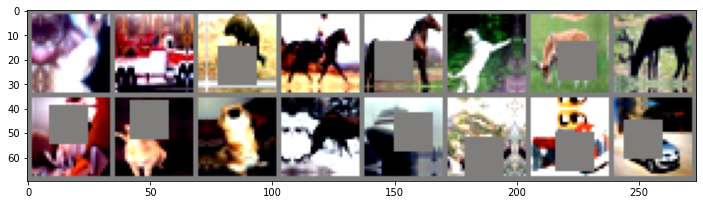

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision 

# functions to show an image
cifar_dataset=train_loader
classes= ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(figsize=(12, 12))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(cifar_dataset)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))

### Model Visualization
Now let's visualize our custom Attention block transformer architecture which is defined in eva8_source repo under [/models/model_9.py](https://github.com/devdastl/eva8_source/blob/main/models/model_9.py).

Since we have already cloned this repo we can directly import it from our directory as mentioned below:

In [4]:
!python -m pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from models.model_9 import TransfromerAttention
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

my_model1 = TransfromerAttention().to(device)

summary(my_model1, input_size=(3,32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
            Conv2d-2           [-1, 32, 28, 28]           4,608
            Conv2d-3           [-1, 48, 26, 26]          13,824
 AdaptiveAvgPool2d-4             [-1, 48, 1, 1]               0
            Linear-5                    [-1, 8]             384
            Linear-6                    [-1, 8]             384
            Linear-7                    [-1, 8]             384
            Linear-8                   [-1, 48]             384
           Ultimus-9                   [-1, 48]               0
           Linear-10                    [-1, 8]             384
           Linear-11                    [-1, 8]             384
           Linear-12                    [-1, 8]             384
           Linear-13                   [-1, 48]             384
          Ultimus-14              

### Setup ModelExecutor module
Now we will setup our main module ModelExecutor which will execute training and evaluation on our defined model architecture.

In [6]:
from main import ModelExecuter
import copy
import torch.optim as optim

start_lr = 1e-6
end_lr = 0.1

net = TransfromerAttention().to(device)

criterion = torch.nn.CrossEntropyLoss()

executer_instance = ModelExecuter(criterion=criterion, device='cuda', 
                                  train_loader=train_loader, test_loader=test_loader)

### Find Learning Rate using LRFinder from torch_lr_finder\
Here we are using Adam optimizer as we are using more "fully connected layer" as compare to convolution layers.

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Min Loss = 2.1898286793389485, Max LR = 0.02477076355991711
LR suggestion: steepest gradient
Suggested LR: 3.43E-03


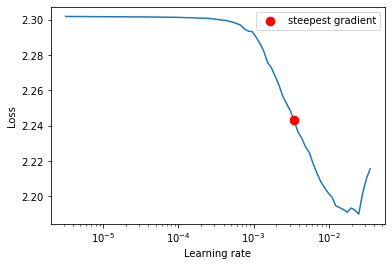

In [7]:
net_exp = copy.deepcopy(net)
optimizer_exp = optim.Adam(net_exp.parameters(), lr=start_lr, weight_decay=0.005)

min_loss, max_lr= executer_instance.find_lr(net_exp, optimizer_exp, end_lr=end_lr, num_iter=100, step_mode='exp')

### setup scheduler and start training loop

In [8]:
EPOCH = 24
optimizer=torch.optim.Adam(net.parameters(), lr=start_lr, weight_decay=0.005)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader),
                                                epochs=EPOCH, pct_start=5/EPOCH, div_factor=10, three_phase=False, final_div_factor=10, anneal_strategy='linear')

lr_hist = executer_instance.execute_training(net, optimizer=optimizer, scheduler=scheduler, NUM_EPOCH=24)

EPOCH: 1


Loss=2.16632342338562 Batch_id=97 Accuracy=17.06: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 0.0042, Accuracy: 1829/10000 (18.29%)

EPOCH: 2


Loss=2.0993382930755615 Batch_id=97 Accuracy=17.88: 100%|██████████| 98/98 [00:12<00:00,  8.03it/s]



Test set: Average loss: 0.0042, Accuracy: 1851/10000 (18.51%)

EPOCH: 3


Loss=2.21449613571167 Batch_id=97 Accuracy=17.94: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]



Test set: Average loss: 0.0042, Accuracy: 1872/10000 (18.72%)

EPOCH: 4


Loss=53460.453125 Batch_id=97 Accuracy=12.45: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]



Test set: Average loss: 78.8262, Accuracy: 1153/10000 (11.53%)

EPOCH: 5


Loss=8123.60498046875 Batch_id=97 Accuracy=10.38: 100%|██████████| 98/98 [00:11<00:00,  8.34it/s]



Test set: Average loss: 21.5946, Accuracy: 1090/10000 (10.90%)

EPOCH: 6


Loss=98.78187561035156 Batch_id=97 Accuracy=10.68: 100%|██████████| 98/98 [00:12<00:00,  8.01it/s]



Test set: Average loss: 0.3239, Accuracy: 969/10000 (9.69%)

EPOCH: 7


Loss=37.39945983886719 Batch_id=97 Accuracy=10.28: 100%|██████████| 98/98 [00:12<00:00,  7.89it/s]



Test set: Average loss: 0.2206, Accuracy: 1183/10000 (11.83%)

EPOCH: 8


Loss=48.299686431884766 Batch_id=97 Accuracy=10.69: 100%|██████████| 98/98 [00:13<00:00,  7.37it/s]



Test set: Average loss: 0.1629, Accuracy: 1436/10000 (14.36%)

EPOCH: 9


Loss=28.019010543823242 Batch_id=97 Accuracy=10.43: 100%|██████████| 98/98 [00:12<00:00,  7.83it/s]



Test set: Average loss: 0.0623, Accuracy: 846/10000 (8.46%)

EPOCH: 10


Loss=10.78714656829834 Batch_id=97 Accuracy=10.83: 100%|██████████| 98/98 [00:12<00:00,  7.82it/s]



Test set: Average loss: 0.0208, Accuracy: 1283/10000 (12.83%)

EPOCH: 11


Loss=11.805686950683594 Batch_id=97 Accuracy=12.26: 100%|██████████| 98/98 [00:12<00:00,  7.78it/s]



Test set: Average loss: 0.0213, Accuracy: 1274/10000 (12.74%)

EPOCH: 12


Loss=16.49659538269043 Batch_id=97 Accuracy=12.61: 100%|██████████| 98/98 [00:12<00:00,  7.85it/s]



Test set: Average loss: 0.0271, Accuracy: 1355/10000 (13.55%)

EPOCH: 13


Loss=9.888238906860352 Batch_id=97 Accuracy=11.15: 100%|██████████| 98/98 [00:12<00:00,  7.76it/s]



Test set: Average loss: 0.0275, Accuracy: 1122/10000 (11.22%)

EPOCH: 14


Loss=42.79979705810547 Batch_id=97 Accuracy=11.02: 100%|██████████| 98/98 [00:12<00:00,  7.73it/s]



Test set: Average loss: 0.0667, Accuracy: 916/10000 (9.16%)

EPOCH: 15


Loss=62.651554107666016 Batch_id=97 Accuracy=10.89: 100%|██████████| 98/98 [00:12<00:00,  7.79it/s]



Test set: Average loss: 0.2112, Accuracy: 951/10000 (9.51%)

EPOCH: 16


Loss=25.682138442993164 Batch_id=97 Accuracy=10.92: 100%|██████████| 98/98 [00:12<00:00,  7.90it/s]



Test set: Average loss: 0.0552, Accuracy: 1004/10000 (10.04%)

EPOCH: 17


Loss=89.62812042236328 Batch_id=97 Accuracy=11.27: 100%|██████████| 98/98 [00:11<00:00,  8.34it/s]



Test set: Average loss: 0.1231, Accuracy: 1176/10000 (11.76%)

EPOCH: 18


Loss=16.413127899169922 Batch_id=97 Accuracy=12.56: 100%|██████████| 98/98 [00:12<00:00,  7.94it/s]



Test set: Average loss: 0.0510, Accuracy: 1049/10000 (10.49%)

EPOCH: 19


Loss=15.465812683105469 Batch_id=97 Accuracy=11.39: 100%|██████████| 98/98 [00:12<00:00,  7.73it/s]



Test set: Average loss: 0.0476, Accuracy: 1317/10000 (13.17%)

EPOCH: 20


Loss=136.10498046875 Batch_id=97 Accuracy=11.66: 100%|██████████| 98/98 [00:12<00:00,  7.81it/s]



Test set: Average loss: 0.3257, Accuracy: 1462/10000 (14.62%)

EPOCH: 21


Loss=18.676441192626953 Batch_id=97 Accuracy=12.47: 100%|██████████| 98/98 [00:12<00:00,  7.82it/s]



Test set: Average loss: 0.0332, Accuracy: 1347/10000 (13.47%)

EPOCH: 22


Loss=6.530598163604736 Batch_id=97 Accuracy=12.58: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 0.0211, Accuracy: 1332/10000 (13.32%)

EPOCH: 23


Loss=9.75550651550293 Batch_id=97 Accuracy=12.66: 100%|██████████| 98/98 [00:12<00:00,  7.74it/s]



Test set: Average loss: 0.0184, Accuracy: 1286/10000 (12.86%)

EPOCH: 24


Loss=7.363772392272949 Batch_id=97 Accuracy=12.73: 100%|██████████| 98/98 [00:12<00:00,  7.80it/s]


generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24

Test set: Average loss: 0.0157, Accuracy: 1299/10000 (12.99%)



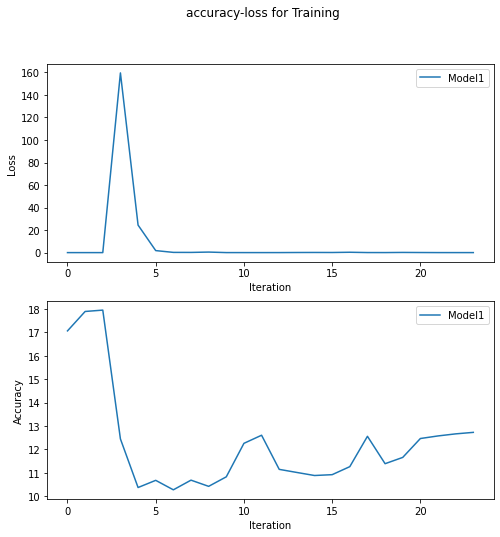

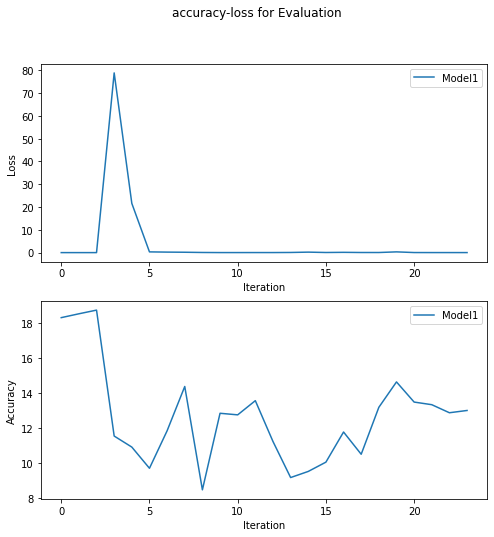

In [9]:
executer_instance.plot_graph()